<a href="https://colab.research.google.com/github/ZaichenkoNA/Stat_Prac/blob/main/Dz5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework

The quality of classification/regression by the k Nearest Neighbors method depends on several parameters:
* the number of neighbors `n_neighbors`
* the distance metric between objects `metric`
* the weights of neighbors (the neighbors of the test example can enter with different weights, for example, the further the example, the less its "voice" is taken into account) `weights`


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression

digits = pd.read_csv('forest_dataset.csv')
X, y = digits[digits.columns[:-1]].values, digits[digits.columns[-1]].values

#Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [4]:
clf = KNeighborsClassifier()

#Определяем параметры для GridSearchCV
params = {
    'n_neighbors': list(range(1, 11)),
    'metric': ['manhattan', 'euclidean'],
    'weights': ['uniform', 'distance']
}
clf_grid = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)
clf_grid.fit(X_train, y_train)
print("Лучшие параметры:", clf_grid.best_params_)

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


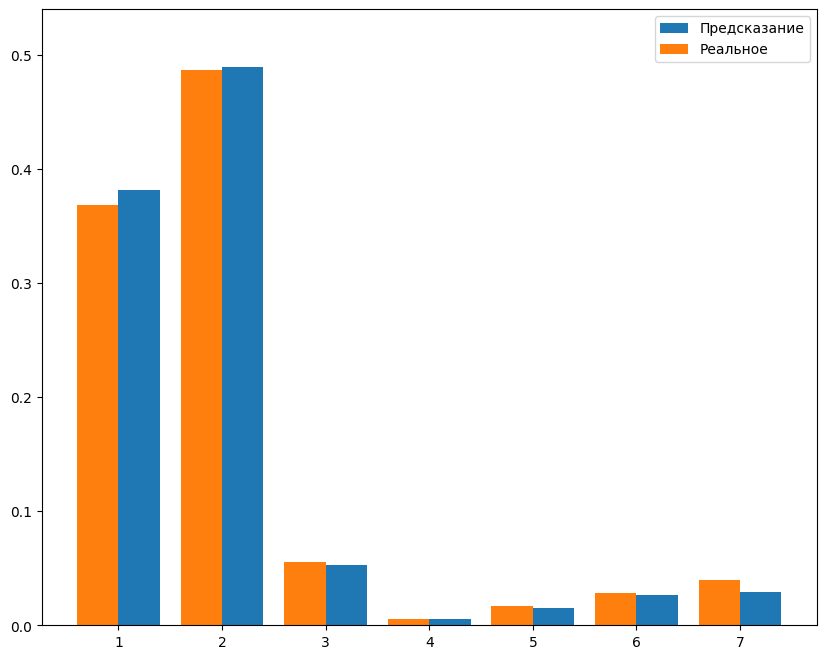

In [6]:
optimal_clf = KNeighborsClassifier(**clf_grid.best_params_)
optimal_clf.fit(X_train, y_train)

#Делаем предсказания вероятностей
pred_prob = optimal_clf.predict_proba(X_test)
#Вычисляем частоту классов в реальной выборке
unique, freq = np.unique(y_test, return_counts=True)
freq = list(map(lambda x: x / len(y_test), freq))

#Вычисляем частоту классов в предсказаниях
pred_freq = pred_prob.mean(axis=0)
x_grid = np.arange(1,8)

#Строим гистограмму
plt.figure(figsize=(10, 8))
plt.bar(x_grid, pred_freq, width=0.4, align="edge", label='Предсказание')
plt.bar(x_grid, freq, width=-0.4, align="edge", label='Реальное')
plt.ylim(0, 0.54)
plt.legend()
plt.show()

In [7]:
#Обучаем логистическую регрессию
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)

#Предсказываем метки классов
y_pred_knn = optimal_clf.predict(X_test)
y_pred_log_reg = log_reg.predict(X_test)

#Оцениваем точность
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)

print(f'Точность KNN: {accuracy_knn:.4f}')
print(f'Точность логистической регрессии: {accuracy_log_reg:.4f}')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Точность KNN: 0.7845
Точность логистической регрессии: 0.7010


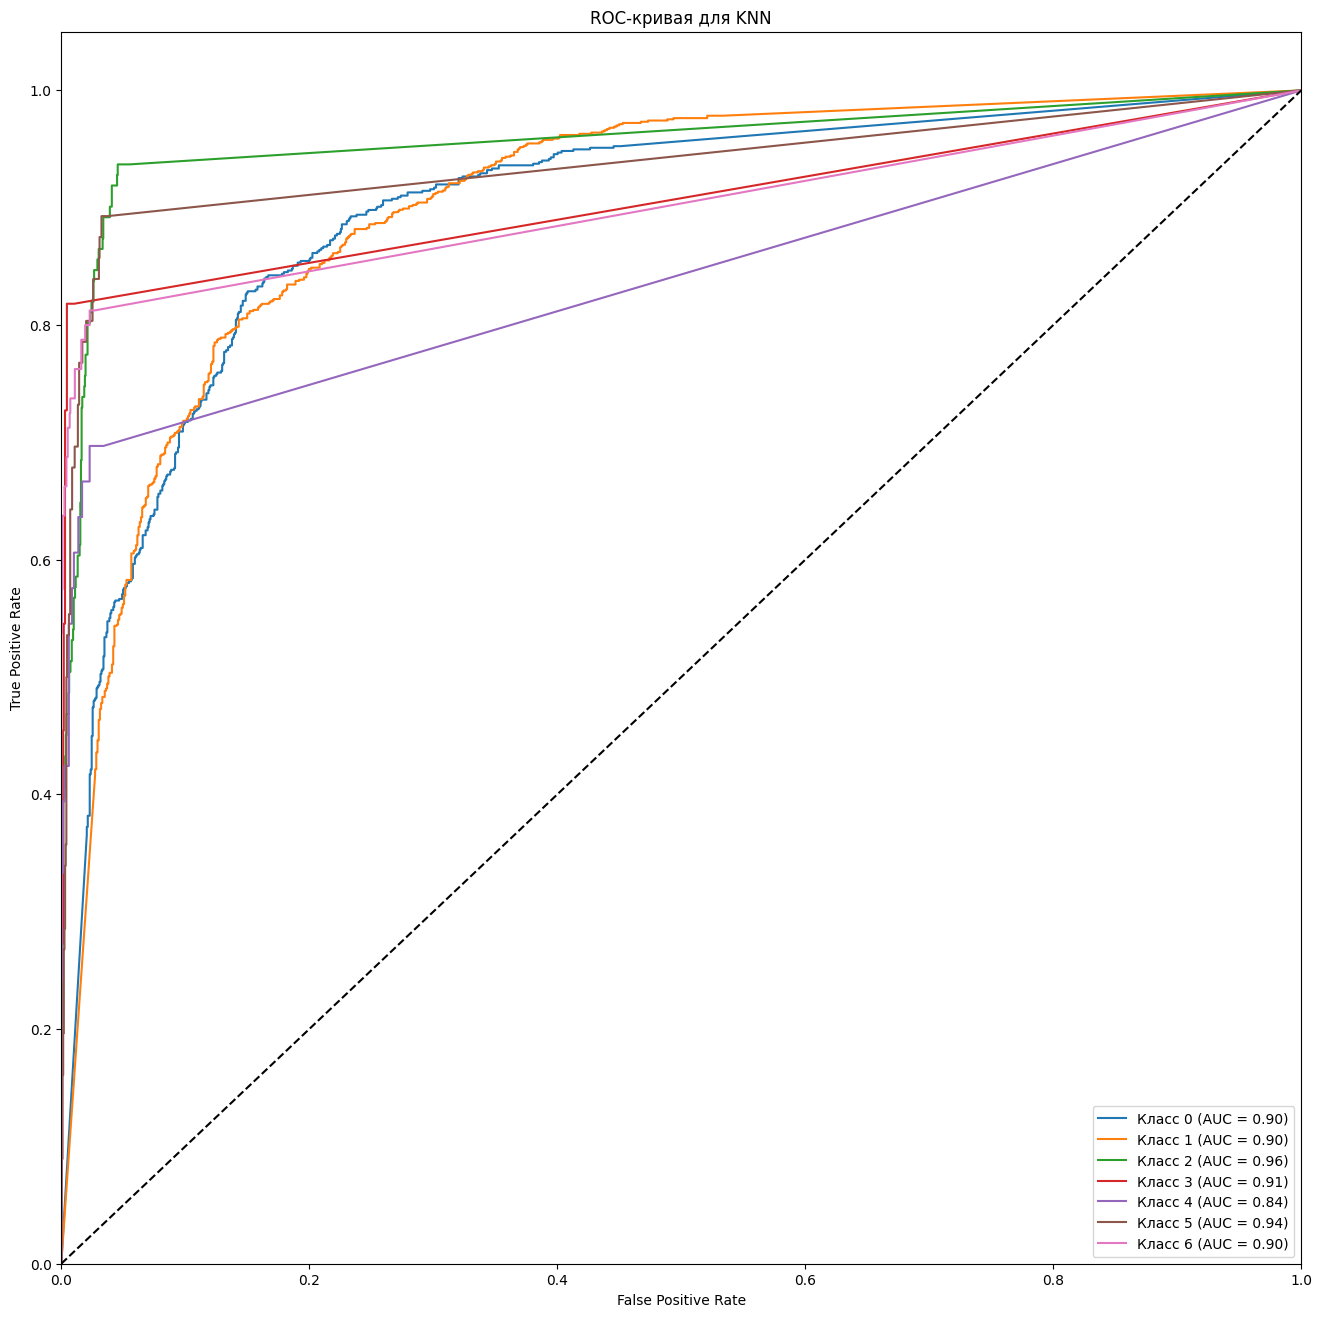

Среднее значение AUC (AUC-ROC): 0.91


In [8]:
#Бинаризуем классы для ROC-AUC анализа
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(16, 16))
roc_auc_values = []

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)
    plt.plot(fpr, tpr, label=f'Класс {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для KNN')
plt.legend(loc="lower right")
plt.show()

mean_auc = np.mean(roc_auc_values)
print(f'Среднее значение AUC (AUC-ROC): {mean_auc:.2f}')

Плюсы и минусы метода k ближайших соседей:

Плюсы: Простой и интуитивно понятный алгоритм. Хорошо работает при наличии нелинейных зависимостей в данных. Не требует обучения модели, лишь хранит данные.

Минусы: Высокая вычислительная сложность. Чувствителен к выбору метрики расстояний и количества соседей. Может плохо работать на многомерных данных.